In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/X_USDINR.csv')
X.drop('Unnamed: 0', axis=1, inplace=True)
X.head()

,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0.002366,0.003777,0.002111,0.000000,0.000000,0.000000,0.0,0.435743,0.428316,0.501290,0.000988,0.000382,0.026881
1,0.002990,0.003444,0.005988,0.000148,0.000077,0.000040,0.0,0.440006,0.429330,0.511641,0.000988,0.000382,0.026881
2,0.000000,0.009943,0.006819,0.000310,0.000162,0.000085,0.0,0.443880,0.431063,0.518980,0.000988,0.000382,0.026881
3,0.000808,0.004527,0.006440,0.000284,0.000152,0.000080,0.0,0.441573,0.431901,0.509839,0.000988,0.000382,0.026881
4,0.003394,0.004238,0.001931,0.000529,0.000282,0.000148,0.0,0.447507,0.433982,0.522539,0.000988,0.000382,0.026881


In [3]:
y = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/Y_USDINR.csv')
y.drop('Unnamed: 0', axis=1, inplace=True)
y.head()

,Closing_price
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565


In [4]:
def directional_accuracy(actual, predicted):
    # Ensure 1D arrays
    actual = np.ravel(actual)
    predicted = np.ravel(predicted)

    # Compute direction change
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare directions
    correct_direction = np.sign(actual_diff) == np.sign(pred_diff)

    return np.mean(correct_direction) * 100

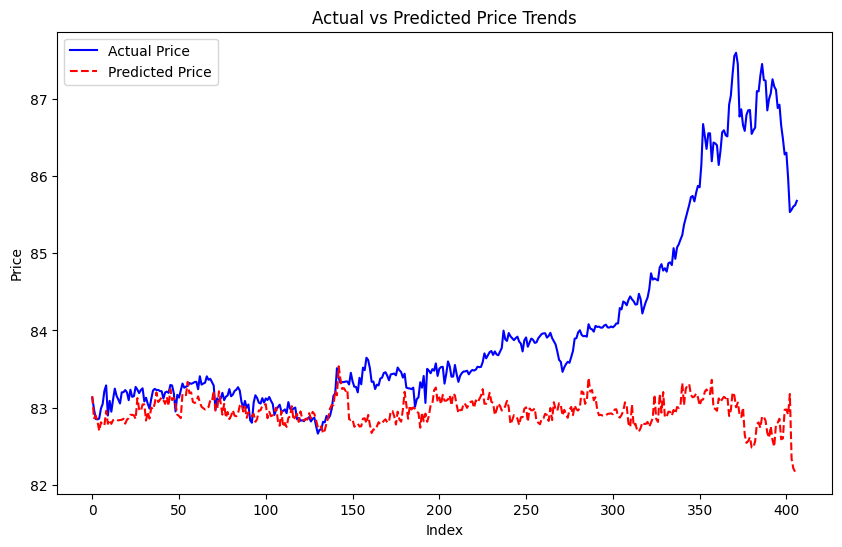

In [5]:
def catboost_model(X,y):
    # Initialize the CatBoost Regressor
    catboost = CatBoostRegressor(
        l2_leaf_reg=15,
        iterations=1000, 
        learning_rate=0.1, 
        depth=10, 
        loss_function='MAE',  # Can be changed to 'RMSE', etc., as needed
        verbose=0  # Set to 0 to suppress training logs
    )
    
    # 85% train, 15% test
    total_size = len(X)
    train_end = int(total_size * 0.85)

    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:], y[train_end:]


    # Train the model
    catboost.fit(X_train, y_train)

    # Make predictions
    y_train_pred = catboost.predict(X_train)  # Predictions on training data
    y_test_pred = catboost.predict(X_test)   # Predictions on testing data

    # Evaluate the model
    testmae = mean_absolute_error(y_test, y_test_pred)
    testmse = mean_squared_error(y_test, y_test_pred)
    testmape = mean_absolute_percentage_error(y_test, y_test_pred)
    testr2 = r2_score(y_test, y_test_pred)

    # Calculate accuracy scores for training and testing
    trainmae = mean_absolute_error(y_train, y_train_pred)
    trainmse = mean_squared_error(y_train, y_train_pred)
    trainmape = mean_absolute_percentage_error(y_train, y_train_pred)
    trainr2 = r2_score(y_train, y_train_pred)

    # Directional Accuracy
    dir_acc = directional_accuracy(y_test, y_test_pred)

    # After calculating the metrics:
    cb_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)",
            "Directional Accuracy %"
        ],
        "Training": [
            trainmae,
            trainmse,
            trainmape * 100, 
            trainr2, 
            (1 - trainmape) * 100,
            np.NaN
        ],
        "Testing": [
            testmae, 
            testmse,
            testmape * 100, 
            testr2, 
            (1 - testmape) * 100,
            dir_acc
        ]
    }

    # Convert to DataFrame
    cb_metrics_df = pd.DataFrame(cb_metrics)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    
    return cb_metrics_df

# Example usage
cb_metrics_df = catboost_model(X,y)

In [6]:
cb_metrics_df

,Metric,Training,Testing
0,Mean Absolute Error (MAE),0.027357,1.060043
1,Mean Squared Error (MSE),0.002850,2.683067
2,Mean Absolute Percentage Error (MAPE),0.038621,1.241177
3,R-squared (R²),0.999917,-0.787402
4,Accuracy (1 - MAPE),99.961379,98.758823
5,Directional Accuracy %,NaN,49.261084
